# Fig. S4. Dendrogram with clustering features

This notebook plots dendrogram with the activation features ($\mathbf{H}$) used for clustering the days.

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
import tsnmf

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## tsNMF decomposition

From previous analysis we selected the tsNMF run with `random_seed=1190`. Here we use this initial condition to perform the decomposition again.

In [6]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [7]:
H_multW = (model.H.T*np.linalg.norm(model.W, axis=0)).T
W_divW = model.W/np.linalg.norm(model.W, axis=0)

## Distance matrix based on activations

In [8]:
from scipy.spatial.distance import pdist, squareform

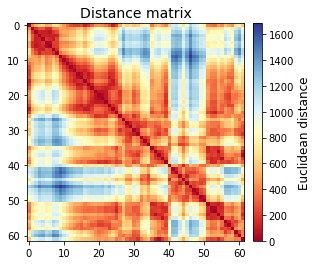

In [9]:
D = pdist(H_multW.T, 'euclidean')

fig,ax = plt.subplots(1,1)
im0 = ax.imshow(squareform(D), cmap='RdYlBu')
ax.set_title('Distance matrix', fontsize=14)

pos = ax.get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02, 
                    pos.y0, 
                    0.02, 
                    pos.y0+pos.height-pos.y0])
plt.ylabel('Euclidean distance', fontsize=14)
cbar = plt.colorbar(im0, cax=cax)
cbar.ax.set_ylabel('Euclidean distance', rotation=90, fontsize=12)

plt.show()

## Dendrogram and clustering

We explore the relationship between the days (based on the activation) using a dendrogram.

In [10]:
from scipy.cluster import hierarchy

In [11]:
link = hierarchy.linkage(D, 'ward')

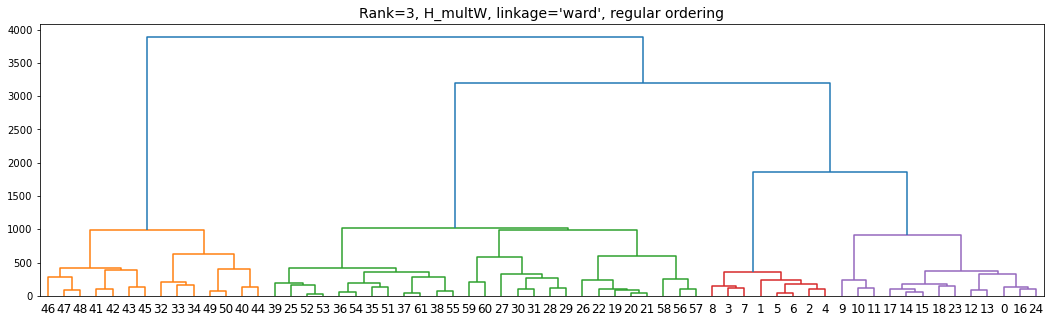

In [12]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(link, leaf_rotation=0, leaf_font_size=12, color_threshold=1500)
plt.title("Rank=3, H_multW, linkage='ward', regular ordering", fontsize=14)
plt.show()

Let's us agglomerative clustering to find the labels for each day.

In [13]:
from sklearn.cluster import AgglomerativeClustering

In [14]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = cluster.fit_predict(H_multW.T)

To visualize this we can use a simple color plot:

In [15]:
labels

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

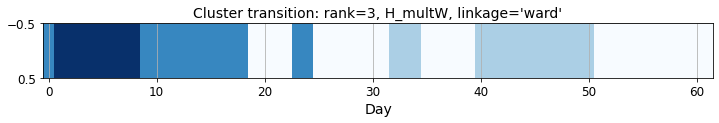

In [16]:
fig = plt.figure(figsize=(12,1))
plt.imshow(np.expand_dims(labels,axis=0), aspect='auto', cmap='Blues')
plt.yticks([-0.5, 0.5], fontsize=12)
plt.xticks(np.arange(0, 62, 10), fontsize=12)
plt.grid()
plt.xlabel('Day', fontsize=14)
plt.title("Cluster transition: rank=3, H_multW, linkage='ward'", fontsize=14)
plt.show()

## Fig. S4. Dendrogram with clustering features

In [17]:
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("ticks")

To color-code the clusters along with the feature heatmap, we need to construct a series and pass it in to `col_colors` in seaborm clustermap.

In [18]:
import matplotlib.colors as colors

In [19]:
labels_ward_series = pd.Series(labels)
labels_ward_series

0     2
1     3
2     3
3     3
4     3
     ..
57    0
58    0
59    0
60    0
61    0
Length: 62, dtype: int64

In [20]:
cmap_cluster = plt.cm.get_cmap('YlGnBu')
boundaries = np.arange(5)
norm = colors.BoundaryNorm(boundaries, cmap_cluster.N, clip=True)

In [21]:
col_color_vals = cmap_cluster((boundaries[:-1]+0.5)/boundaries.max())
col_color_vals = col_color_vals[[labels_ward_series.unique()],:].squeeze()
col_color_vals

array([[0.11410996, 0.56470588, 0.75109573, 1.        ],
       [0.14197616, 0.2014456 , 0.5739331 , 1.        ],
       [0.92882737, 0.97231834, 0.69416378, 1.        ],
       [0.49517878, 0.80286044, 0.73374856, 1.        ]])

In [22]:
clu_color = dict(zip(labels_ward_series.unique(), col_color_vals))
col_colors = labels_ward_series.map(clu_color)

Let's make a dataframe out of the normalized activation for clustermap to function on.

In [23]:
df_activation = pd.DataFrame(H_multW.T, columns=['#1', '#2', '#3'])
df_activation

,#1,#2,#3
0,1824.941014,1164.042893,1242.414174
1,1842.481845,787.825336,1364.943523
2,1716.863951,655.477814,1376.476547
3,1627.059598,641.860238,1466.905971
4,1684.161592,556.605981,1394.416161
...,...,...,...
57,1548.386448,1546.456485,1082.249845
58,1477.588992,1360.261574,1057.130112
59,1581.727401,1685.729697,813.190972
60,1747.968986,1765.356799,709.796113


Now we are ready to plot:

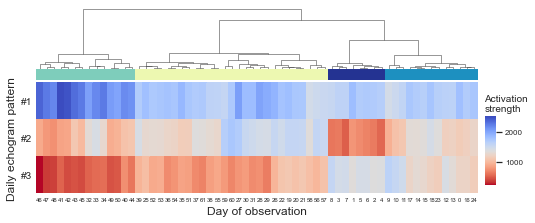

In [24]:
g = sns.clustermap(df_activation.T, cmap='coolwarm_r', 
                   method='ward', row_cluster=False, col_colors=col_colors, 
                   xticklabels=1,
                   figsize=(7+1/16,4),
                   cbar_pos=[.1, .15, .02, .35])

g.ax_heatmap.set_xlabel('Day of observation', fontsize=12)
g.ax_heatmap.set_ylabel('Daily echogram pattern', fontsize=12, rotation=90)
g.ax_heatmap.tick_params(axis='both', which='major', length=0)
g.ax_heatmap.tick_params(axis='y', which='major', labelleft=True, labelright=False)
g.ax_heatmap.yaxis.set_label_position('left')
g.ax_col_colors.set_yticks([])
plt.text(0, 2700, s='Activation\nstrength', fontsize=10)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, ha='right', rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=6, ha='center', rotation=0)
plt.setp(g.cax.yaxis.get_majorticklabels(), fontsize=8)

# Adjust axis locations
hm_pos=g.ax_heatmap.get_position()
clr_pos=g.ax_col_colors.get_position()
cd_pos=g.ax_col_dendrogram.get_position()
cbar_pos=g.cax.get_position()
g.ax_heatmap.set_position([hm_pos.x0-0.2, hm_pos.y0, hm_pos.width*1.2, hm_pos.height*0.6])
g.ax_col_colors.set_position([hm_pos.x0-0.2, 
                              hm_pos.y0+hm_pos.height*0.6+0.01, 
                              hm_pos.width*1.2, clr_pos.height*1.5])
g.ax_col_dendrogram.set_position([hm_pos.x0-0.2, 
                                  hm_pos.y0+hm_pos.height*0.6+0.01+clr_pos.height*1.5, 
                                  hm_pos.width*1.2, cd_pos.height*1.3])
g.cax.set_position([hm_pos.x0-0.2+hm_pos.width+0.16, cbar_pos.y0, cbar_pos.width, cbar_pos.height*0.68])


plt.savefig('../figs/fig_si_dendrogram.pdf', 
            bbox_inches = 'tight', pad_inches = 0.01)
plt.show()